In [ ]:
import xarray as xr
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import re
from tensorflow.keras.layers import Input, ConvLSTM2D, TimeDistributed, Conv2D, BatchNormalization, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from skimage.measure import block_reduce


# Amazon bounds
lat_min, lat_max = -15, 5
lon_min, lon_max = -70, -50

sif_amazon = []
time_list = []

data_dir = data_dir = "/Users/carmenoliver/Desktop/SIF_anomalies/SIF_DATA_TROPOMI/"

# Get all available files
files = sorted([f for f in os.listdir(data_dir) if f.endswith(".nc")])
print("Files found:", files)
for file in files:
    match = re.search(r"month-(\d{6})", file)
    if match:
        date_str = match.group(1)  # Extract YYYYMM
        year = int(date_str[:4])  
        month = int(date_str[4:6])  

        file_path = os.path.join(data_dir, file)
        
        try:
            ds = xr.open_dataset(file_path)
        except Exception as e:
            print(f"Error opening {file_path}: {e}")
            continue
        ds_amazon = ds.sel(latitude=slice(lat_min, lat_max), longitude=slice(lon_min, lon_max))
        
        sif_amazon.append(ds_amazon["solar_induced_fluorescence"].values)  # Shape: [time, lat, lon]
        time_list.append(f"{year}-{month:02d}")
        # Ensure data was loaded
if not sif_amazon or not time_list:
    raise ValueError("No valid data found. Check the input files and filtering logic.")
# Convert to numpy array
sif_amazon = np.stack(sif_amazon, axis=0).squeeze()  # Shape: [N_months, lat, lon]

# Group into years
years = sorted(set(int(t.split("-")[0]) for t in time_list))

num_years = len(years)

# Initialize an empty array with NaNs
sif_monthly = np.full((num_years, 12, *sif_amazon.shape[1:]), np.nan)
# Fill in available months
for i, month_data in enumerate(sif_amazon):
    year_idx = i // 12  # Get year index
    month_idx = i % 12  # Get month index
    sif_monthly[year_idx, month_idx] = month_data  # Assign data

print("Fixed sif_monthly shape:", sif_monthly.shape)
# solar_induced_fluorescence_uncertainty         (time, latitude, longitude) float32 537MB .
#solar_induced_fluorescence_uncertainty_weight  (time, latitude, longitude) float32 537MB ...

Files found: ['s5p-l3grd-sif-001-month-20190101-20240325.nc', 's5p-l3grd-sif-001-month-20190201-20240325.nc', 's5p-l3grd-sif-001-month-20190301-20240325.nc', 's5p-l3grd-sif-001-month-20190401-20240325.nc', 's5p-l3grd-sif-001-month-20190501-20240325.nc', 's5p-l3grd-sif-001-month-20190601-20240325.nc', 's5p-l3grd-sif-001-month-20190701-20240325.nc', 's5p-l3grd-sif-001-month-20190801-20240325.nc', 's5p-l3grd-sif-001-month-20190901-20240325.nc', 's5p-l3grd-sif-001-month-20191001-20240325.nc', 's5p-l3grd-sif-001-month-20191101-20240325.nc', 's5p-l3grd-sif-001-month-20191201-20240325.nc', 's5p-l3grd-sif-001-month-20200101-20240325.nc', 's5p-l3grd-sif-001-month-20200201-20240325.nc', 's5p-l3grd-sif-001-month-20200301-20240325.nc', 's5p-l3grd-sif-001-month-20200401-20240325.nc', 's5p-l3grd-sif-001-month-20200501-20240325.nc', 's5p-l3grd-sif-001-month-20200601-20240325.nc', 's5p-l3grd-sif-001-month-20200701-20240325.nc', 's5p-l3grd-sif-001-month-20200801-20240325.nc', 's5p-l3grd-sif-001-month-2

In [18]:
has_nans = np.isnan(sif_monthly).any()
print("Does sif_monthly contain NaNs?", has_nans)
# Calculate the mean of sif_monthly ignoring NaNs
mean_sif_monthly = np.nanmean(sif_monthly)

# Replace NaNs in sif_monthly with the calculated mean
sif_monthly = np.nan_to_num(sif_monthly, nan=mean_sif_monthly)
# Compute climatology: Average across years per month (ignoring NaNs)
climatology = np.nanmean(sif_monthly, axis=0)  

# Compute monthly means: Average over spatial dimensions
monthly_means = np.nanmean(climatology, axis=(1, 2))  # Shape: (12,)

# Compute overall mean SIF across all months
overall_mean_sif = np.nanmean(monthly_means)

# Create a climatology table
months = ['January', 'February', 'March', 'April', 'May', 'June',
          'July', 'August', 'September', 'October', 'November', 'December']

climatology_table = pd.DataFrame({
    'Month': months,
    'Avg SIF': np.round(monthly_means, 3)  # Rounded to 3 decimals
})

# Convert the climatology table to a LaTeX table
latex_table = climatology_table.to_latex(index=False, caption="Monthly Climatology Summary", label="tab:climatology", float_format="%.3f")
#print(latex_table)

print("Monthly Climatology Summary:")
print(climatology_table)

print("\nOverall Mean SIF:", round(overall_mean_sif, 3))



has_nans = np.isnan(sif_monthly).any()
print("Does sif_monthly contain NaNs?", has_nans)


Does sif_monthly contain NaNs? True
Monthly Climatology Summary:
        Month  Avg SIF
0     January    1.461
1    February    1.359
2       March    1.317
3       April    1.248
4         May    1.192
5        June    1.129
6        July    1.095
7      August    1.050
8   September    1.061
9     October    1.266
10   November    1.439
11   December    1.500

Overall Mean SIF: 1.26
Does sif_monthly contain NaNs? False


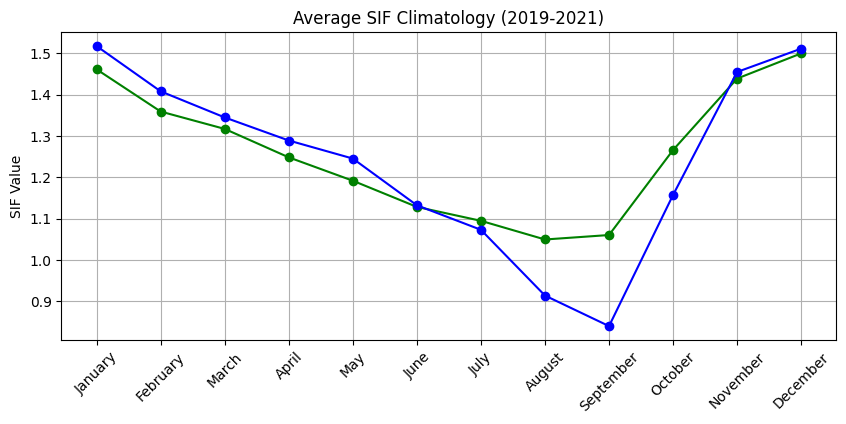

In [19]:
plt.figure(figsize=(10,4))
plt.plot(months, monthly_means, marker='o', color='green')
plt.plot(months, sif_monthly[5,:,:,:].mean(axis=(1, 2)), marker='o', color='blue', label='Monthly Mean SIF') #here it seems we are not getting 
plt.title("Average SIF Climatology (2019-2021)")
plt.ylabel("SIF Value")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

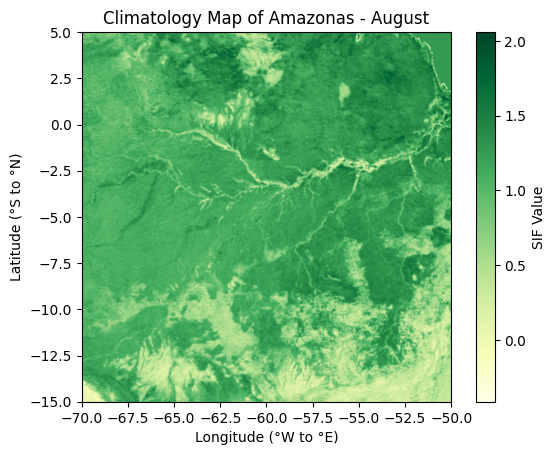

In [20]:
# Choose a month (0-11)
month_idx = 7  # August
plt.imshow(climatology[month_idx], cmap='YlGn', origin = 'lower',  extent=[lon_min, lon_max, lat_min, lat_max])
plt.colorbar(label='SIF Value')
plt.xlabel("Longitude (°W to °E)")
plt.ylabel("Latitude (°S to °N)")
plt.title(f"Climatology Map of Amazonas - {months[month_idx]}")
plt.show()
# Add a map of the area with coordinates#

sif_strided shape: (6, 81, 12, 101, 101)
Reshaped sif_strided shape: (6, 81, 12, 100, 100)
sif_patches_combined shape: (486, 12, 100, 100)


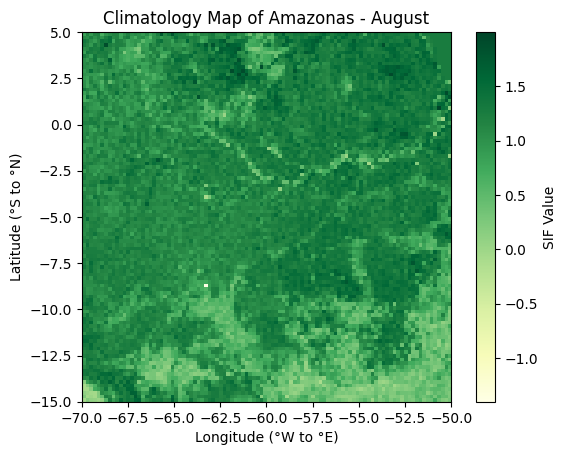

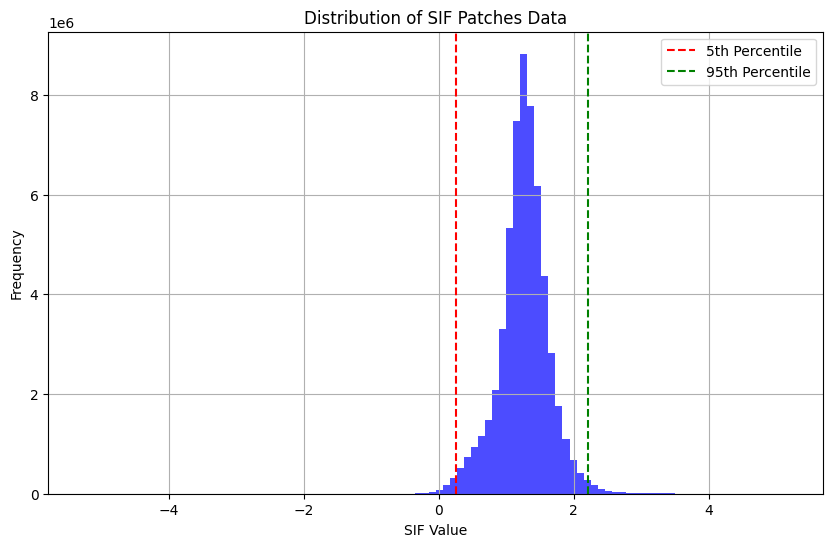

In [135]:

def create_strided_downsamples(data, modulo):
    years, months, h, w = data.shape

    # Crop to make h and w divisible by modulo
    new_h = (h // modulo) * modulo
    new_w = (w // modulo) * modulo
    cropped = data[..., :new_h, :new_w]

    versions = []
    for row_mod in range(modulo):
        for col_mod in range(modulo):
            version = cropped[..., row_mod::modulo, col_mod::modulo]
            versions.append(version)

    return np.stack(versions, axis=1)
sif_strided = create_strided_downsamples(sif_monthly,9) 
print("sif_strided shape:", sif_strided.shape)  # Should be (6, 4, 12, h', w')
# Resize the data to 100x100 instead of 101x101
sif_strided = sif_strided[:, :, :, :100, :100]
print("Reshaped sif_strided shape:", sif_strided.shape)
# Flatten into fake "years"
sif_patches = sif_strided.reshape(-1, 12, sif_strided.shape[-2], sif_strided.shape[-1])
print("sif_patches_combined shape:", sif_patches.shape)

# Choose a month (0-11)
month_idx = 7  # August
plt.imshow(sif_patches[102,month_idx], cmap='YlGn', origin = 'lower',  extent=[lon_min, lon_max, lat_min, lat_max])
plt.colorbar(label='SIF Value')
plt.xlabel("Longitude (°W to °E)")
plt.ylabel("Latitude (°S to °N)")
plt.title(f"Climatology Map of Amazonas - {months[month_idx]}")
plt.show()

# Flatten the sif_patches_combined array to a 1D array for distribution plotting
sif_patches_flat = sif_patches.flatten()

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.hist(sif_patches_flat, bins=100, color='blue', alpha=0.7)

# Calculate the 5th and 95th percentiles
percentile_5 = np.percentile(sif_patches_flat, 1)
percentile_95 = np.percentile(sif_patches_flat, 99)

# Add vertical lines for the 5th and 95th percentiles
plt.axvline(percentile_5, color='red', linestyle='--', label='5th Percentile')
plt.axvline(percentile_95, color='green', linestyle='--', label='95th Percentile')

# Add legend to the plot
plt.legend()
plt.title("Distribution of SIF Patches Data")
plt.xlabel("SIF Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()



In [140]:
from keras import regularizers
from keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, Cropping3D
from keras.models import Model
# Improved normalization: Clip extreme values to reduce the impact of outliers
sif_monthly_clipped = np.clip(sif_patches, np.percentile(sif_patches, 1), np.percentile(sif_patches, 99))

input_sequences = sif_monthly_clipped[..., np.newaxis]  # Add channel dimension

# Input shape: (sequence_length, lat, lon, 1)
#input_seq = Input(shape=(12, sif_monthly.shape[2], sif_monthly.shape[3], 1))
# Define input with fixed batch size of 1

# Define the input layer: (time, height, width, channels)  
input_seq = Input(shape=(12, sif_monthly_clipped.shape[2], sif_monthly_clipped.shape[3] , 1))  # omit batch size here

# Encoder
x = Conv3D(16, (3, 3, 3), activation='relu', padding='same')(input_seq)     
x = MaxPooling3D((2, 2, 2), padding='same')(x)                             
x = Conv3D(8, (3, 3, 3), activation='relu', padding='same')(x)             
encoded = MaxPooling3D((2, 2, 2), padding='same', activity_regularizer=regularizers.l1(1e-5))(x)                     

# Decoder
x = Conv3D(8, (3, 3, 3), activation='relu', padding='same')(encoded)        
x = UpSampling3D((2, 2, 2))(x)                                            
x = Conv3D(16, (3, 3, 3), activation='relu', padding='same')(x)            
x = UpSampling3D((2, 2, 2))(x)              
#x = Cropping3D(cropping=((0,0), (0,3), (0,3)))(x)                            # → (12, 101, 101, 16)
decoded = Conv3D(1, (3, 3, 3), activation='relu', padding='same')(x)   

# Model
autoencoder = Model(input_seq, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()


Model: "functional_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_36 (InputLayer)     │ (None, 12, 100, 100,   │             0 │
│                                 │ 1)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_139 (Conv3D)             │ (None, 12, 100, 100,   │           448 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_58 (MaxPooling3D) │ (None, 6, 50, 50, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_140 (Conv3D)             │ (None, 6, 50, 50, 8)   │         3,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_59 (MaxPooling3D) │ (None, 3, 25, 25, 8)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_141 (Conv3D)             │ (None, 3, 25, 25, 8)   │         1,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling3d_55 (UpSampling3D) │ (None, 6, 50, 50, 8)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_142 (Conv3D)             │ (None, 6, 50, 50, 16)  │         3,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling3d_56 (UpSampling3D) │ (None, 12, 100, 100,   │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_143 (Conv3D)             │ (None, 12, 100, 100,   │           433 │
│                                 │ 1)                     │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,553 (37.32 KB)

 Trainable params: 9,553 (37.32 KB)

 Non-trainable params: 0 (0.00 B)

In [141]:

autoencoder.fit(input_sequences, input_sequences, 
                epochs=50, 
                batch_size=10, 
                shuffle=True)

Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 827ms/step - loss: 0.9923
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 827ms/step - loss: 0.2330
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 833ms/step - loss: 0.1280
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 834ms/step - loss: 0.1027
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 830ms/step - loss: 0.0899
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 829ms/step - loss: 0.0838
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 838ms/step - loss: 0.0793
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 837ms/step - loss: 0.0759
Epoch 9/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 839ms/step - loss: 0.0739
Epoch 10/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 846ms/step - loss: 0.0712
Epoch 11/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 43s 875ms/step - loss: 0.0690
Epoch 12/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 46s 930ms/step - loss: 0.0681
Epoch 13/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 45s 921ms/step - loss: 0.0670
Epoch 14/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 45s 916ms/step - loss: 0.0665
Epoch 15/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 44s 

In [144]:
# extract encoder output
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer("max_pooling3d_59").output)
encoded_imgs = encoder.predict(sif_patches[..., np.newaxis])
print("Encoded images shape:", encoded_imgs.shape)  # Should be (num_sequences, new_h, new_w, 8)

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 193ms/step
Encoded images shape: (486, 3, 25, 25, 8)


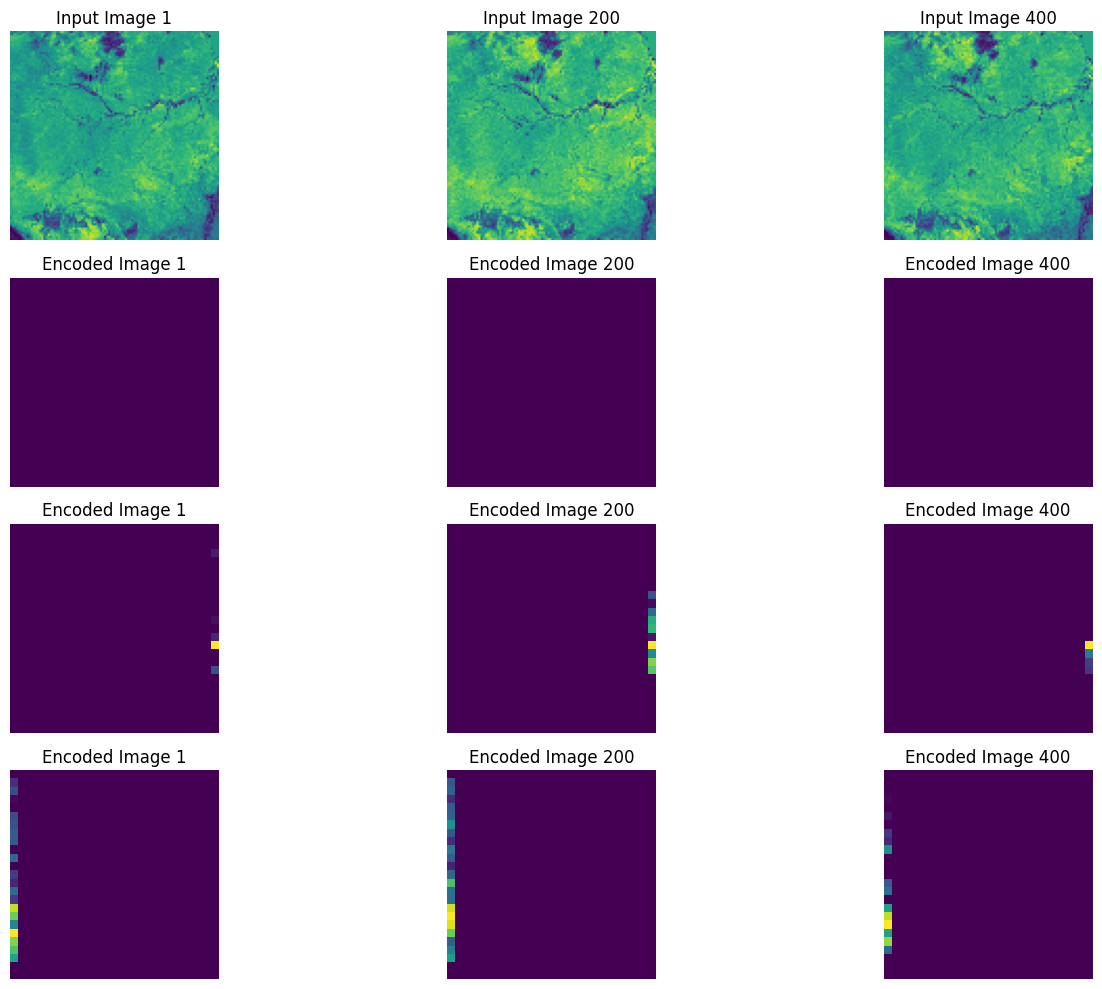

In [145]:
# Visualize some encoded images
num_images_to_plot = 3

indices_to_plot = [0, 199, 399]

# Visualize the input images corresponding to the encoded images
fig, axes = plt.subplots(4, num_images_to_plot, figsize=(15, 10))

for i, idx in enumerate(indices_to_plot):
    # Plot the input image
    input_image = sif_monthly_clipped[idx, :, :, :] 
    axes[0, i].imshow(input_image.mean(axis=0), cmap='viridis', origin='lower')  # Mean projection along one axis
    axes[0, i].set_title(f"Input Image {idx+1}")
    axes[0, i].axis('off')

    # Plot the encoded image
    encoded_image = encoded_imgs[idx, :, :, :, 0]  # Select the first channel of the encoded image
    axes[1, i].imshow(encoded_image[0], cmap='viridis', origin='lower')  # Mean projection along one axis
    axes[1, i].set_title(f"Encoded Image {idx+1}")
    axes[1, i].axis('off')

    # Plot the encoded image
    encoded_image = encoded_imgs[idx, :, :, :, 0]  # Select the first channel of the encoded image
    axes[2, i].imshow(encoded_image[1], cmap='viridis', origin='lower')  # Mean projection along one axis
    axes[2, i].set_title(f"Encoded Image {idx+1}")
    axes[2, i].axis('off')

    # Plot the encoded image
    encoded_image = encoded_imgs[idx, :, :, :, 0]  # Select the first channel of the encoded image
    axes[3, i].imshow(encoded_image[2], cmap='viridis', origin='lower')  # Mean projection along one axis
    axes[3, i].set_title(f"Encoded Image {idx+1}")
    axes[3, i].axis('off')

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
(6, 12, 100, 100, 1)


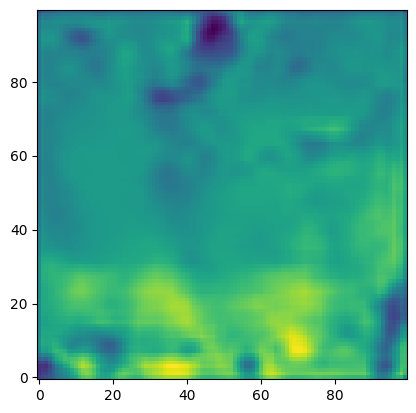

In [151]:
from skimage.transform import resize

# Step 1: Prepare input with proper dimensions
# Downsize sif_monthly to have shape (6, 12, 100, 100)

# Resize each year's data to (12, 100, 100)
sif_monthly_resized = np.empty((sif_monthly.shape[0], sif_monthly.shape[1], 100, 100))
for year_idx in range(sif_monthly.shape[0]):
    for month_idx in range(sif_monthly.shape[1]):
        sif_monthly_resized[year_idx, month_idx] = resize(
            sif_monthly[year_idx, month_idx],
            (100, 100),
            anti_aliasing=True
        )


input_data = sif_monthly_resized[..., np.newaxis]  # shape: (6, 12, 100,100 , 1)

# Step 2: Predict reconstructions (you must loop or batch because batch size = 1)
reconstructed = np.zeros_like(input_data)
for i in range(len(sif_monthly_resized)):  # For each year
    inp = input_data[i:i+1]  # shape: (1, 12, 911, 910, 1)
    reconstructed[i:i+1] = autoencoder.predict(inp)

# Step 3: Compute reconstruction error per datapoint
reconstruction_error = np.mean((input_data - reconstructed) ** 2, axis=-1)  # shape: (6, 12, 911, 910)
print(reconstructed.shape)

plt.imshow(reconstructed[0, 0, :, :, 0], label='Reconstructed', origin='lower')
plt.show()


In [152]:
# Evaluate the model on the test set:
score = autoencoder.evaluate(sif_monthly_resized, sif_monthly_resized)
print('Test reconstruction loss (MSE):', score)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0297
Test reconstruction loss (MSE): 0.029732488095760345


In [153]:
print(np.min(input_sequences), np.max(input_sequences), np.mean(input_sequences))


0.25397312074899675 2.2080979371070857 1.2606664906539662


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


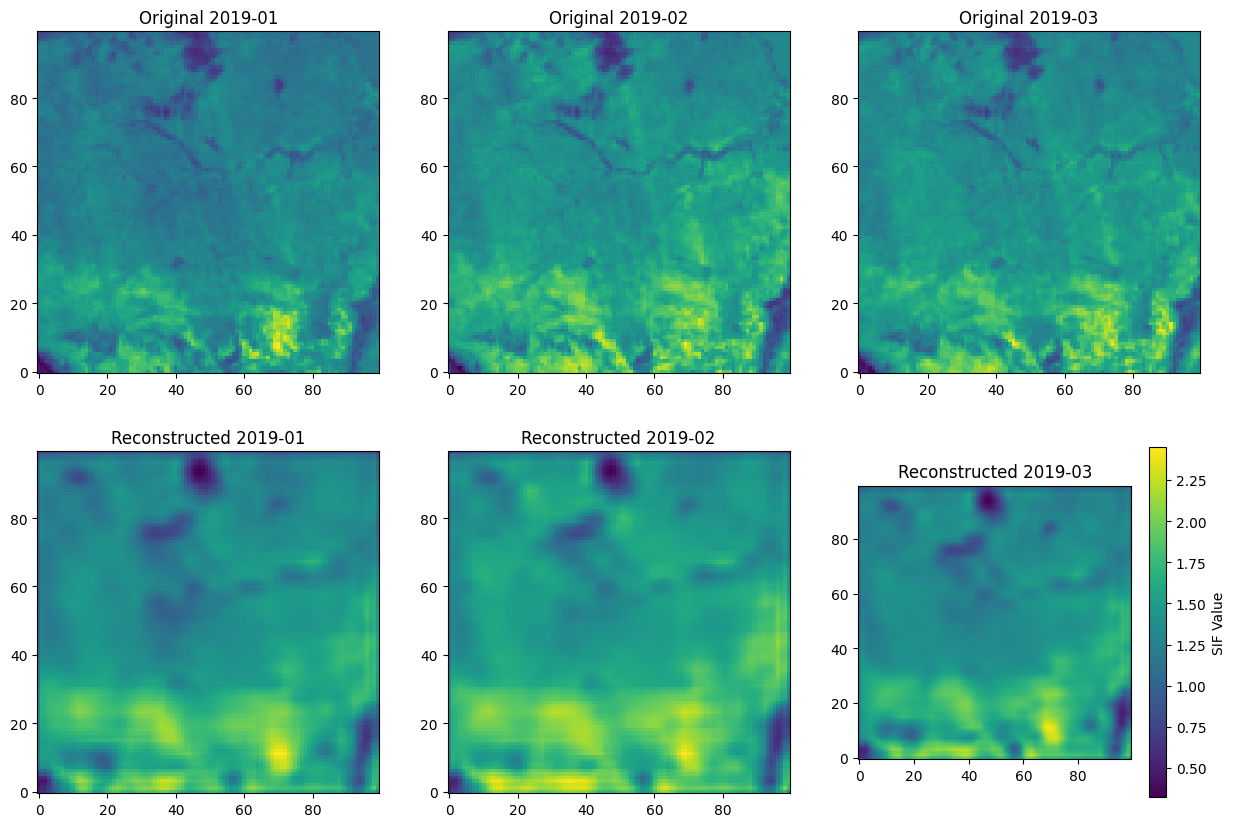

In [160]:
reconstructed_imgs = autoencoder.predict(sif_monthly_resized[..., np.newaxis])
# Adjust the dimensions for visualization
plt.figure(figsize=(15, 10))  # Increase the figure size
n = 3  # Number of images to display
for i in range(3):
    # Original image
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(sif_monthly_resized[i+2, 0], cmap='viridis', origin='lower')
    ax.set_title(f"Original {time_list[i]}")

    # Reconstructed image
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(reconstructed_imgs[i+2, 0], cmap='viridis', origin='lower')
    ax.set_title(f"Reconstructed {time_list[i]}")
    
plt.colorbar(label='SIF Value')
plt.show()

Monthly min errors: [2.25792693e-14 4.04537526e-12 1.17661647e-11 9.66630980e-12
 5.51847964e-12 9.61881451e-12 1.72075454e-15 4.02420533e-12
 7.61554464e-13 3.60415303e-16 1.94723134e-11 6.05232015e-12] Monthly max errors: [2.40046363 1.8340552  1.65038001 2.4962843  2.22348528 1.59843242
 0.66269255 0.63628115 1.00506342 0.91164772 3.18164497 3.23309041]


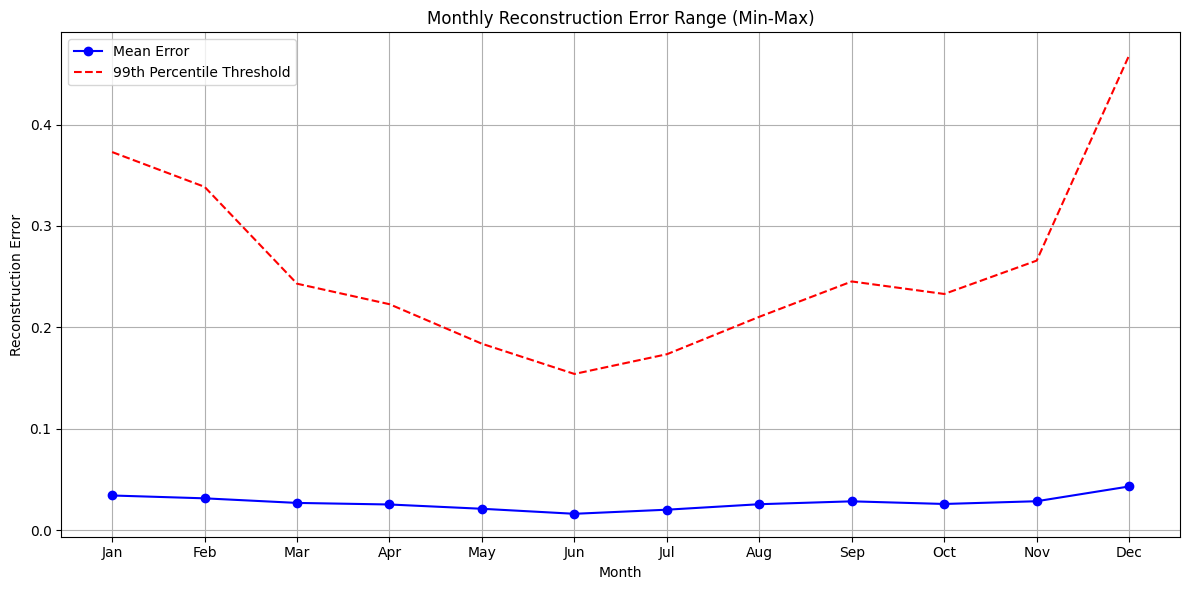

(6, 12, 100, 100)


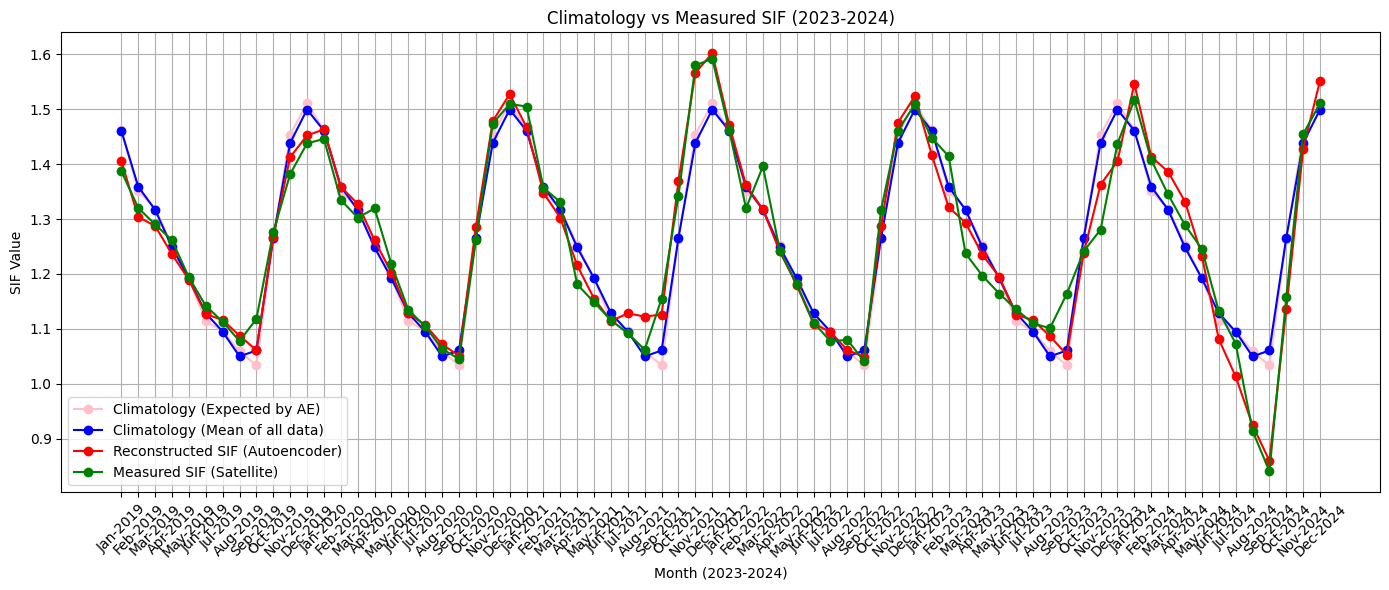

Least reconstruction error index: (np.int64(5), np.int64(9), np.int64(48), np.int64(1))
Least reconstruction error value: 3.604153028519177e-16


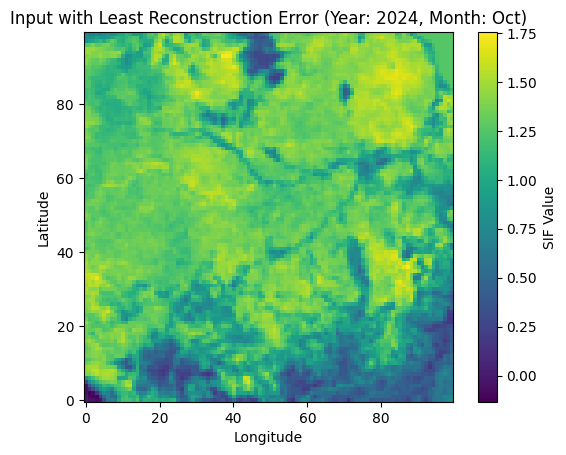

In [155]:

thresholds_per_month = np.percentile(reconstruction_error, 99, axis=(0, 2, 3))  # shape: (12,)

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']


# Compute min, max, and mean errors per year and month
min_errors = np.min(reconstruction_error, axis=(2, 3))  # shape: (6, 12)
max_errors = np.max(reconstruction_error, axis=(2, 3))  # shape: (6, 12)
mean_errors = np.mean(reconstruction_error, axis=(2, 3))  # shape: (6, 12)

# Aggregate across years to get monthly min/max (alternative: keep per-year)
monthly_min = np.min(min_errors, axis=0)  # Min across years (shape: 12)
monthly_max = np.max(max_errors, axis=0)  # Max across years (shape: 12)

# Or to show yearly variability, plot each year's min-max as a band:
# monthly_min = min_errors[year, :], monthly_max = max_errors[year, :]

# Plot
plt.figure(figsize=(12, 6))
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

print("Monthly min errors:", monthly_min, "Monthly max errors:", monthly_max)

# Plot mean/median (optional)
plt.plot(range(12), mean_errors.mean(axis=0), 'b-', label='Mean Error', marker='o')

# Percentile threshold
plt.plot(range(12), thresholds_per_month, 'r--', label='99th Percentile Threshold')

plt.xticks(range(12), months)
plt.xlabel('Month')
plt.ylabel('Reconstruction Error')
plt.title('Monthly Reconstruction Error Range (Min-Max)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


anomalies_month = reconstruction_error > thresholds_per_month.reshape(1, 12, 1, 1)  #anomalies per month not subject to pixel
print(anomalies_month.shape)
# Compute the usual climatology of SIF per month

# Extend the months list to include 24 months for 2023-2024
extended_months = [f"{month}-{year}" for year in [2019, 2020, 2021, 2022, 2023, 2024] for month in months]

# Concatenate the climatology and measured SIF for 2023-2024
climatology_24_months = np.mean(climatology, axis = (1,2)) # Shape: (24,)
climatology_24_months = np.tile(climatology_24_months, 6)  # Repeat the 12-month climatology 6 times
climatology_AE = np.mean(reconstructed, axis = (0,2,3,4))
climatology_AE = np.tile(climatology_AE, 6)
AE_reconstruction = np.mean(reconstructed, axis = (2,3,4)).flatten() 
sif_measured_24_months = np.mean(sif_monthly, axis = (2,3)).flatten()  # Shape: (24,)


plt.figure(figsize=(14, 6))
plt.plot(extended_months, climatology_AE, label="Climatology (Expected by AE)", color="pink", marker="o")
plt.plot(extended_months, climatology_24_months, label="Climatology (Mean of all data)", color="blue", marker="o")
plt.plot(extended_months, AE_reconstruction, label="Reconstructed SIF (Autoencoder)", color="red", marker="o")
plt.plot(extended_months, sif_measured_24_months, label="Measured SIF (Satellite)", color="green", marker="o")

plt.xlabel("Month (2023-2024)")
plt.ylabel("SIF Value")
plt.title("Climatology vs Measured SIF (2023-2024)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Find the input with the least reconstruction error
least_error_idx = np.unravel_index(np.argmin(reconstruction_error), reconstruction_error.shape)
least_error_input = input_data[least_error_idx[0], least_error_idx[1]]

print(f"Least reconstruction error index: {least_error_idx}")
print(f"Least reconstruction error value: {reconstruction_error[least_error_idx]}")

# Visualize the input with the least reconstruction error
plt.imshow(least_error_input.squeeze(), cmap='viridis', origin='lower')
plt.colorbar(label='SIF Value')
plt.title(f"Input with Least Reconstruction Error (Year: {years[least_error_idx[0]]}, Month: {months[least_error_idx[1]]})")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()




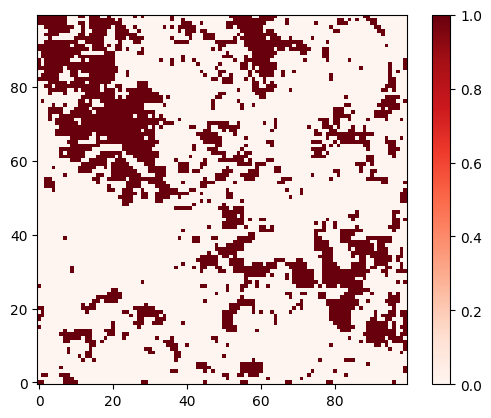

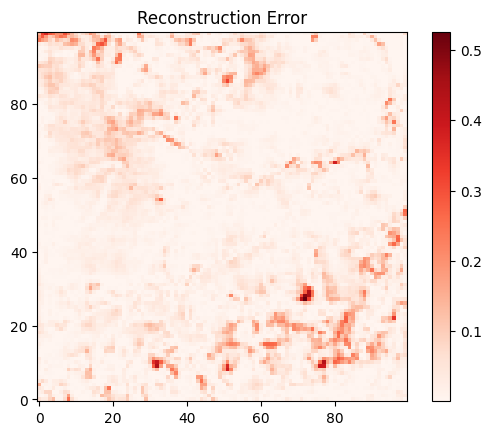

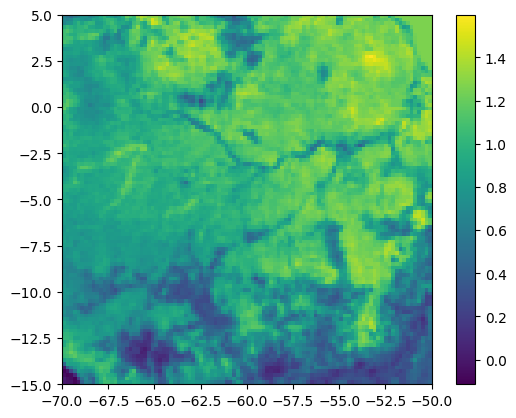

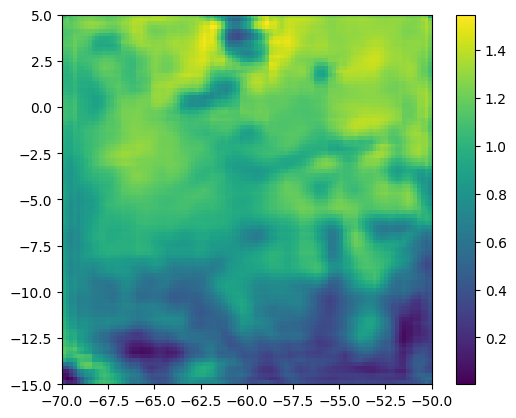

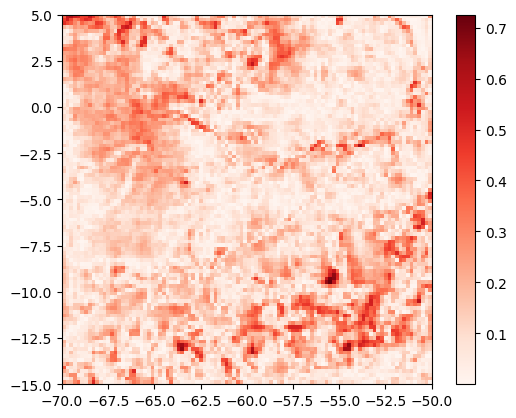

In [161]:

mean_errors_per_year = np.max(reconstruction_error, axis=(2, 3))  # shape: (6, 12)

thresholds_per_month = np.percentile(reconstruction_error, 99, axis= (0))  # shape: (12, 100, 100)
anomalies = reconstruction_error > thresholds_per_month.reshape(1, 12,100, 100)  # Broadcasting

plt.imshow(anomalies[5, 7], cmap='Reds', origin= 'lower')  # Red = anomaly
plt.colorbar()
plt.show()
plt.imshow(reconstruction_error[5, 7], cmap='Reds', origin='lower')
plt.colorbar()
plt.title("Reconstruction Error")
plt.show()
plt.imshow(sif_monthly_resized[5, 7], cmap='viridis', origin= 'lower',  extent=[lon_min, lon_max, lat_min, lat_max])
plt.colorbar()
plt.show()
plt.imshow(reconstructed[5, 7], cmap='viridis', origin= 'lower',  extent=[lon_min, lon_max, lat_min, lat_max])
plt.colorbar()
plt.show()
plt.imshow(abs(reconstructed[5, 7] - sif_monthly_resized[5,7].reshape(100,100,1)), cmap='Reds', origin= 'lower',  extent=[lon_min, lon_max, lat_min, lat_max])
plt.colorbar()
plt.show()

In [ ]:
#we have to figure out how to make the anomalies be found on the sif_monthly so we can figure out which year it belongs to... 

Reconstruction error shape: (6, 12, 100, 100)


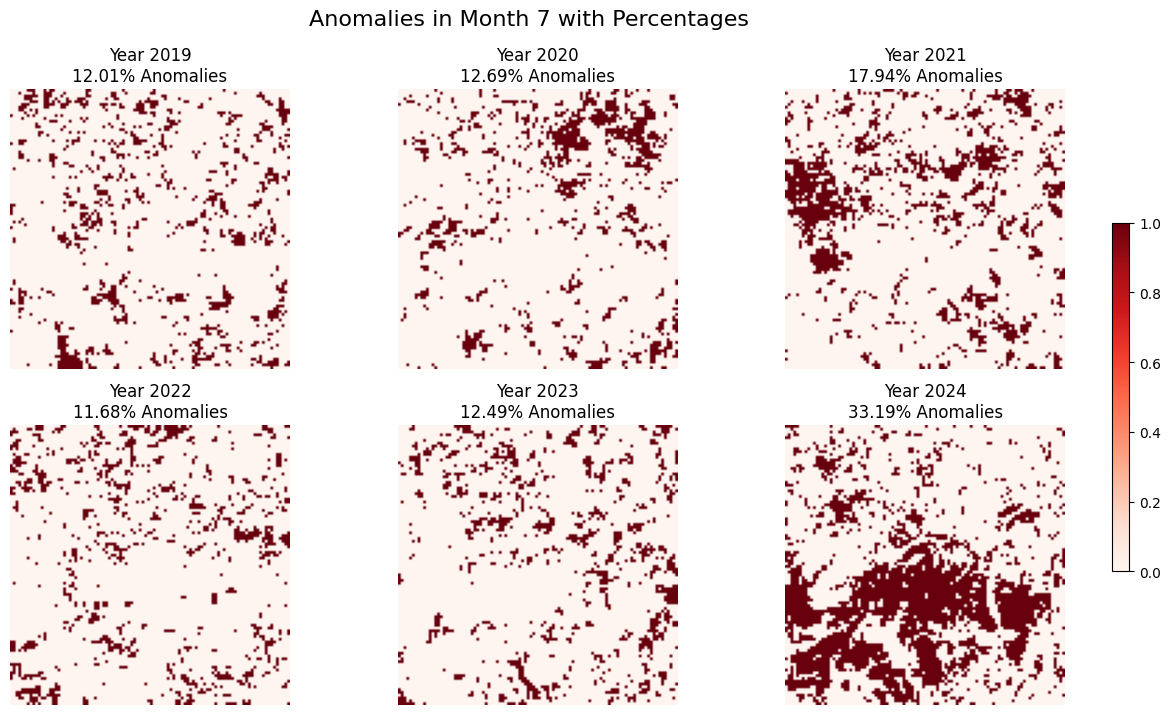

Highlighted Anomaly Percentages Table:
       2019        2020        2021        2022        2023        2024
Jan  13.58%      12.79%      16.61%      14.84%      17.77%  24.41% !!!
Feb  12.73%      13.71%      10.65%      14.09%  30.34% !!!  18.48% !!!
Mar  13.20%      10.66%      16.88%  22.56% !!!      14.83%  21.87% !!!
Apr  14.99%  23.36% !!!      11.40%       9.44%  19.20% !!!  21.61% !!!
May  17.99%      12.46%      10.31%      11.45%  19.15% !!!  28.64% !!!
Jun  14.37%      15.14%      13.59%      14.32%      10.78%  31.80% !!!
Jul  12.01%      12.69%      17.94%      11.68%      12.49%  33.19% !!!
Aug  15.02%      12.64%  24.47% !!!       8.40%      14.26%  25.21% !!!
Sep  14.57%       7.72%      15.38%      12.18%  29.89% !!!  20.26% !!!
Oct  13.51%      11.79%  19.15% !!!      14.35%  19.06% !!!  22.14% !!!
Nov  11.71%      13.11%      17.79%      13.33%  26.05% !!!  18.01% !!!
Dec  11.27%      12.62%      17.17%      17.39%  22.55% !!!  19.00% !!!
\begin{table}
\caption{Mo

/var/folders/wj/pgnjjx3n5dg6p90187_803300000gn/T/ipykernel_27852/2623391574.py:72: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  anomaly_percentages_df_highlighted = anomaly_percentages_df.applymap(


In [192]:
reconstruction_error = np.abs(reconstructed.squeeze(-1) - sif_monthly_resized)  
print("Reconstruction error shape:", reconstruction_error.shape)  # shape: (6, 12, 100, 100)
thresholds_per_month = np.percentile(reconstruction_error, 99, axis= (0)) 
#print("Thresholds per month:", thresholds_per_month)  # shape: (12, 100, 100) 
anomalies = reconstruction_error > thresholds_per_month


anomaly_list = []

for year in range(anomalies.shape[0]):
    for month in range(12):
        lat_idx, lon_idx = np.where(anomalies[year, month])
        for i in range(len(lat_idx)):
            anomaly_list.append({
                'year': 2019 + year,  # adjust this based on your start year
                'month': month + 1,
                'lat_idx': lat_idx[i],
                'lon_idx': lon_idx[i],
                'error': reconstruction_error[year, month, lat_idx[i], lon_idx[i]]
            })

anomaly_df = pd.DataFrame(anomaly_list)


month_idx = 6

# Calculate the percentage of anomalies per year for the selected month
anomaly_percentages = []
for year_idx in range(anomalies.shape[0]):
    total_pixels = anomalies[year_idx, month_idx].size
    anomaly_pixels = np.sum(anomalies[year_idx, month_idx])
    anomaly_percentage = (anomaly_pixels / total_pixels) * 100
    anomaly_percentages.append(anomaly_percentage)

# Add the percentage of anomalies to the map titles
fig, axs = plt.subplots(2, 3, figsize=(15, 8))  # 6 years → 2 rows × 3 columns
fig.suptitle(f"Anomalies in Month {month_idx + 1} with Percentages", fontsize=16)

for year_idx in range(6):
    ax = axs[year_idx // 3, year_idx % 3]
    anomaly_map = anomalies[year_idx, month_idx]  # shape: (100, 100)
    
    im = ax.imshow(anomaly_map, cmap='Reds', origin='lower')
    ax.set_title(f"Year {2019 + year_idx}\n{anomaly_percentages[year_idx]:.2f}% Anomalies")
    ax.axis('off')

fig.colorbar(im, ax=axs, orientation='vertical', fraction=0.015, pad=0.04)
plt.show()


# Calculate the percentage of anomalies for each month over the 6 years
anomaly_percentages_table = []

for month_idx in range(12):
    monthly_percentages = []
    for year_idx in range(anomalies.shape[0]):
        total_pixels = anomalies[year_idx, month_idx].size
        anomaly_pixels = np.sum(anomalies[year_idx, month_idx])
        anomaly_percentage = (anomaly_pixels / total_pixels) * 100
        monthly_percentages.append(anomaly_percentage)
    anomaly_percentages_table.append(monthly_percentages)

# Create a DataFrame for better visualization
anomaly_percentages_df = pd.DataFrame(
    anomaly_percentages_table,
    columns=years,
    index=months
)


# Highlight percentages above 18 with exclamation marks
anomaly_percentages_df_highlighted = anomaly_percentages_df.applymap(
    lambda x: f"{x:.2f}%" + (" !!!" if x > 18 else "")
)

# Display the highlighted table
print("Highlighted Anomaly Percentages Table:")
print(anomaly_percentages_df_highlighted)

# Optionally, save the highlighted table to a CSV file
anomaly_percentages_df_highlighted.to_csv("amazonas_anomaly_percentages_highlighted.csv")

# Convert the anomaly_percentages_df_highlighted to LaTeX format
latex_code = anomaly_percentages_df_highlighted.to_latex(
    index=True, 
    caption="Monthly Anomaly Percentages Highlighted", 
    label="tab:anomaly_percentages", 
    escape=False
)

# Save the LaTeX code to a file
with open("anomaly_percentages_table.tex", "w") as f:
    f.write(latex_code)

# Print the LaTeX code
print(latex_code)

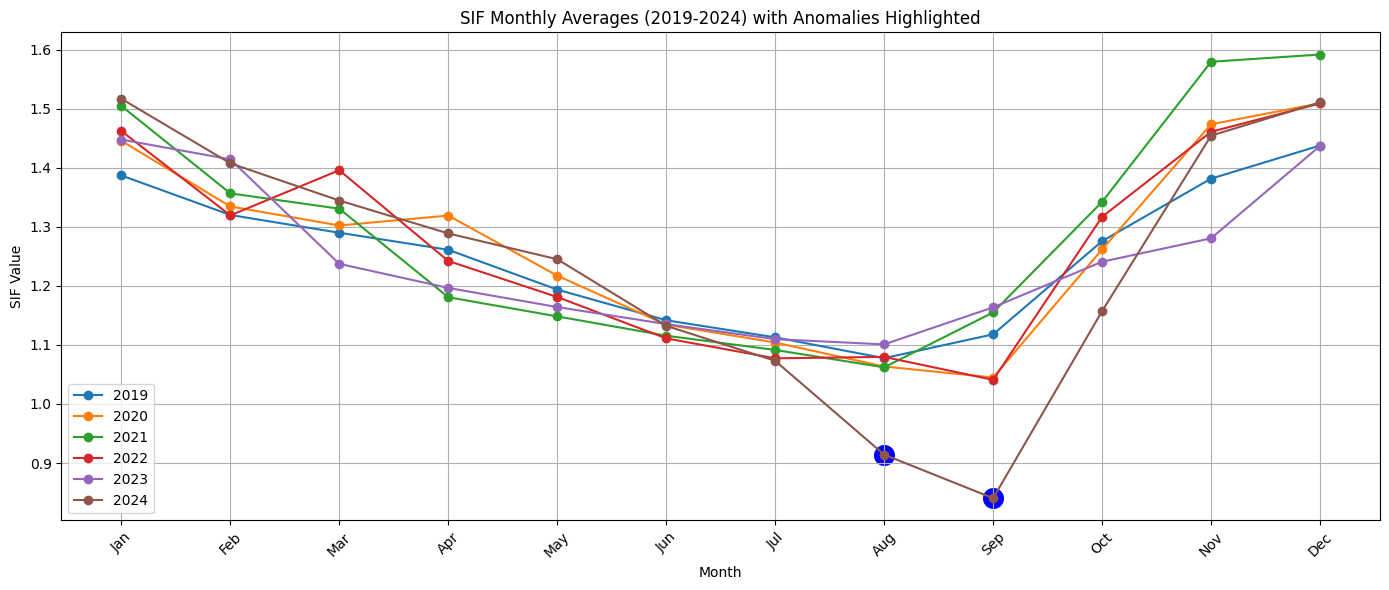

(486, 12, 100, 100)


TypeError: Invalid shape () for image data

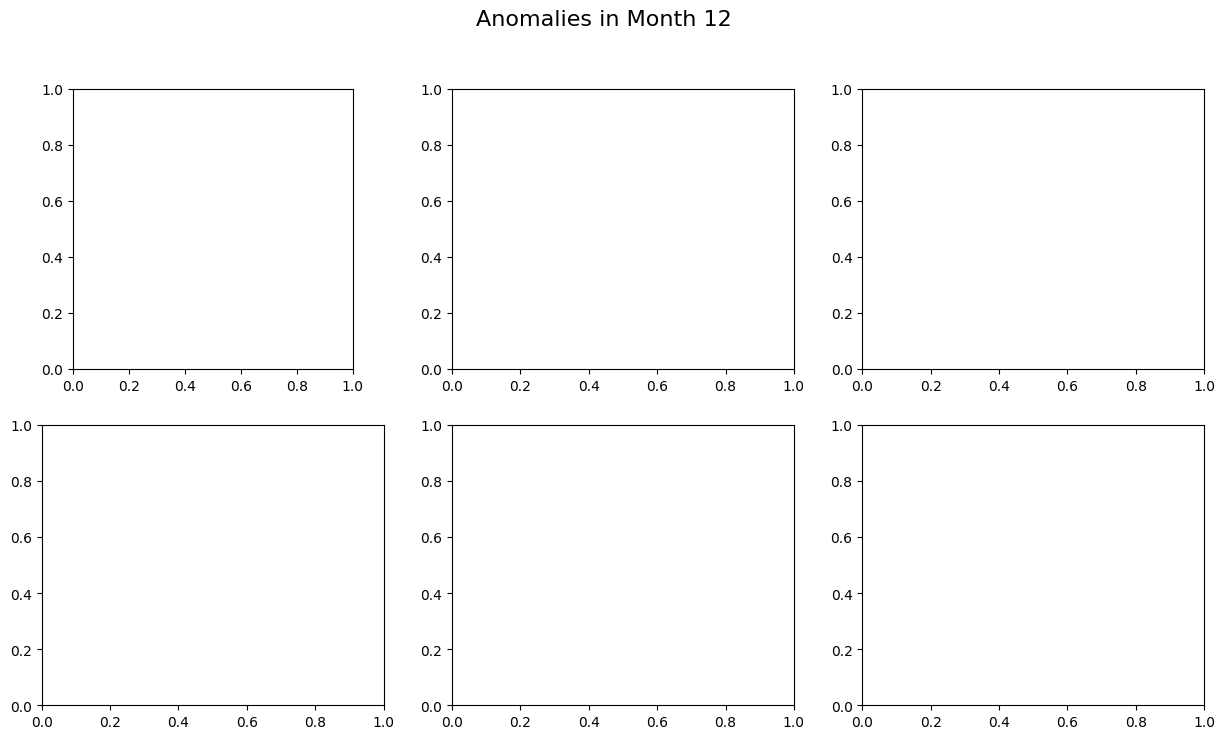

In [164]:

sif_avg = np.mean(sif_monthly, axis=(2, 3))  # shape: (6, 12)

# Monthly climatology
climatology_avg = np.mean(sif_avg, axis=0)  # shape: (12,)
climatology_std = np.std(sif_avg, axis=0)

# Anomalies and mask
sif_anomalies_avg = sif_avg - climatology_avg  # shape: (6, 12)
anomaly_mask_avg = np.abs(sif_anomalies_avg) > 2 * climatology_std

plt.figure(figsize=(14, 6))
for year_idx, year in enumerate(years):
    plt.plot(range(1, 13), sif_avg[year_idx], label=f"{year}", marker='o')

# Highlight anomalies
for year_idx, year in enumerate(years):
    for month_idx in range(12):
        if anomaly_mask_avg[year_idx, month_idx]:
            plt.scatter(month_idx + 1, sif_avg[year_idx, month_idx], color='Blue', s=200, label='Anomaly' if year_idx == 0 and month_idx == 0 else "")

plt.xticks(range(1, 13), months, rotation=45)
plt.xlabel("Month")
plt.ylabel("SIF Value")
plt.title("SIF Monthly Averages (2019-2024) with Anomalies Highlighted")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Mean SIF seasonal cycle across years (shape: 12, lat, lon)
mean_seasonal_sif = sif_monthly_clipped.mean(axis=0)
print(sif_monthly_clipped.shape)
# Subtract seasonal baseline from each year
anomalies = np.abs(mean_seasonal_sif[None, ...] - sif_monthly_resized)


month_idx = 11

fig, axs = plt.subplots(2, 3, figsize=(15, 8))  # 6 years → 2 rows × 3 columns
fig.suptitle(f"Anomalies in Month {month_idx + 1}", fontsize=16)

for year_idx in range(6):
    ax = axs[year_idx // 3, year_idx % 3]
    anomaly_map = anomaly_mask_avg[year_idx, month_idx]  # shape: (100, 100)
    
    im = ax.imshow(anomaly_map, cmap='Reds', origin='lower')
    ax.set_title(f"Year {2019+ year_idx}")
    ax.axis('off')

fig.colorbar(im, ax=axs, orientation='vertical', fraction=0.015, pad=0.04)
#plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()




# Select the specific month (August, index 7)
month_idx = 11  # August

# Extract SIF values for all years and the specific month
sif_august = sif_monthly[:, month_idx, :, :]  # shape: (6, lat, lon)

# Calculate the climatology (mean and standard deviation) for August across all years
climatology_august_mean = np.mean(sif_august, axis=0)  # shape: (lat, lon)
climatology_august_std = np.std(sif_august, axis=0)  # shape: (lat, lon)

# Calculate anomalies for August
sif_anomalies_august = sif_august - climatology_august_mean  # shape: (6, lat, lon)

# Create an anomaly mask for August (absolute anomalies greater than 2 standard deviations)
anomaly_mask_august = np.abs(sif_anomalies_august) > 2 * climatology_august_std  # shape: (6, lat, lon)

# Plot anomalies for each year
fig, axs = plt.subplots(2, 3, figsize=(15, 10))  # 6 years → 2 rows × 3 columns
fig.suptitle("SIF Anomalies for August (2019-2024)", fontsize=16)

for year_idx, ax in enumerate(axs.flat):
    anomaly_map = anomaly_mask_august[year_idx]  # shape: (lat, lon)
    im = ax.imshow(anomaly_map, cmap='Reds', origin='lower', extent=[lon_min, lon_max, lat_min, lat_max])
    ax.set_title(f"Year: {years[year_idx]}")
    ax.axis('off')

fig.colorbar(im, ax=axs, orientation='vertical', fraction=0.02, pad=0.04)
plt.show()
